---
Project for the Research Module in Econometrics and Statistics | Winter Semester 2021-2022 | University of Bonn
[Hugo Foerster-Baldenius](https://github.com/hugo-fb) and [Muhammad Danial Syed](https://github.com/CasualDan) <br>

---
# Working tite: Valid Inference using Machine Learning in a semiparametric setting
#### by Hugo Foerster-Baldenius and Muhammad Danial Syed

This notebook contains our project based on Double Machine Learning method introduced in [Double/debiased machine learning for treatment and structural parameters](https://academic.oup.com/ectj/article/21/1/C1/5056401) (Chernozhukov et al., 2018).

#### Viewing the notebook
The best way to view this notebook is to download the entire GitHub repository dedicated to the project, and operating it via Jupyter Notebooks. Mathematical symbols used throughout the notebook will then be rendered properly. <br>

The following packages are used throughout the notebook, so make sure to have them installed prior to running.
- [DoubleML](https://docs.doubleml.org/stable/index.html)
- [MLR3 Learners](https://mlr3learners.mlr-org.com)

#### Source material
The project uses the above DoubleML package for its main computations and also relies on certain modifications of the [source code](https://github.com/DoubleML/doubleml-for-r) to alter the data generating process in testing the confoundedness assumption of the method.

---
## Part 1: Simulation Study
---

### 1. Setup

#### 1.1 Initialization 

In [1]:
rm(list=ls())

library(DoubleML)
library(ggplot2)
library(mlr3)
library(mlr3learners)
library(repr)
library(data.table)
library(mvtnorm)
suppressMessages(library(parallel))
suppressMessages(library(ggplot2))
suppressMessages(library(doMC))
lgr::get_logger("mlr3")$set_threshold("warn")

numCores <- detectCores()
registerDoMC(cores = numCores)

#### 1.2 Using LASSO as the Machine Learning Method for Estimating $g_{0}$ and $m_{0}$

In [2]:
# LASSO Estimation Function
est_lasso <- function(obj_dml_data) {
    
    #set.seed(70)
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat <- learner$clone()                                  # use LASSO to estimate nuisance g() and m()
    m_hat <- learner$clone()
    
    DML_PLR  <- DoubleMLPLR$new(obj_dml_data, g_hat, m_hat)   # initialize the DML Partially Linear Model 
    DML_PLR$fit()                                             # Fit the model and extract coefficient estimates
    theta_hat <- DML_PLR$coef
    sd_hat    <- DML_PLR$se
    params    <- cbind(theta_hat,sd_hat)
    return(params)
}

#### 1.3a Default Data Generating Process

In [ ]:
default_dgp <- function(n_obs,dim_x,theta) {
    
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1)))
    a_0 = 1
    a_1 = 0.25
    b_1 = 0.25
    
    x <- rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat)
    
    m_0_x <- a_0 * x[, 1] + a_1 * (exp(x[, 3]) /(1 + exp(x[, 3])))
    g_0_x <- exp(x[, 1]) /(1 + exp(x[, 1])) + b_1 * x[, 3]
    
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    d <- as.matrix(m_0_x + eps)
    y <- as.matrix(theta*d + g_0_x + ups)

    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)   
}

#### 1.3b Custom Data Generating Process - Unconfounded

In [ ]:
unconfounded_DGP <- function(n_obs,dim_x,theta,seed,s) {
    
    set.seed(seed)
    
    # multiplicatives in nuisance functions  
    a_1 = 0.25
    b_1 = 0.25
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # Toeplitz covariance matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1)))
    
    x  <- rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat) 
    
    # nuisance parameter m_0 and propensity function d
    m_0_x <- x[,1] + a_1 * (exp(x[,3]) /(1 + exp(x[,3])))
    d     <- as.matrix(m_0_x + eps)
    
    # nuisance paraneter g_0 and outcome y
    beta  <- c(rep(0,3), rnorm(s), rep(0,dim_x-s-3))
    g_0_x <- exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3] +  x %*% beta
    y <- as.matrix(theta*d + g_0_x + ups)

    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
}  


#### 1.3c Custom Data Generating Process - Pre-treatment confounder

In [ ]:
# pre treatment confounder: test at n_con = 1, 3, or 5.
confounded_DGP_PRE <- function(n_obs,dim_x,theta,seed,n_con,s) {
    
    set.seed(seed)
    a_1 = 0.25
    b_1 = 0.25
    c_1 = 0.8
    c_2 = 0.2
    
    u1  <- rnorm(n_obs)  # unobserved
    u2  <- rnorm(n_obs)  # unobserved correlation with y
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # constructing covariates matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1 - n_con)))
    
    x     <- rmvnorm(n = n_obs, mean = rep(0, dim_x-n_con), sigma = cov_mat)        # covariate matrix, unconfounded
    x_con <- matrix(rnorm(n_obs * n_con), ncol = n_con) + sqrt(c_1) * u1 + sqrt(c_2) * u2    # bad controls
    x     <- cbind(x,x_con)
    
    # nuisance parameter m_0 and propensity function d
    m_0_x <- x[,1] + a_1 * (exp(x[,3])/(1 + exp(x[,3]))) 
    d     <- as.matrix(m_0_x + sqrt(c_1) * u1 + eps)
    
    # nuisance paraneter g_0
    beta  <- c(rep(0,4), rep(1,s), rep(0,dim_x-s-4))
    g_0_x <-  exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3] +  x %*% beta
    
    y <- as.matrix(theta*d + g_0_x + sqrt(c_2) * u2 + ups)

    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
} 

#### 1.3d Custom Data Generating Process - Post-treatment confounder

In [ ]:
# post treatment confounder: test at n_con = 1, 3, or 5.
confounded_DGP_POST <- function(n_obs,dim_x,theta,seed,n_con,s) {
    
    set.seed(seed)
    a_1 = 0.25
    b_1 = 0.25
    c_1 = 0.8  
    c_2 = 0.2
    
    u  <- rnorm(n_obs)  # unobserved
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # constructing covariates matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1 - n_con)))
    
    x     <- rmvnorm(n = n_obs, mean = rep(0, dim_x-n_con), sigma = cov_mat)        # covariate matrix, unconfounded
    
    # nuisance parameter m_0 and propensity function d
    m_0_x <- x[,1] + a_1 * (exp(x[,3])/(1 + exp(x[,3])))
    d     <- m_0_x + eps
    
    # post treatment confounder
    x_con <- matrix(rnorm(n_obs * n_con), ncol = n_con) + c_1 * d + sqrt(c_2) * u
    x     <- cbind(x,x_con)
    d     <- as.matrix(d)
    
    # nuisance parameter g_0
    beta  <- c(rep(0,4), rep(1,s), rep(0,dim_x-s-4))
    g_0_x <-  exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3] +  x %*% beta
    
    y <- as.matrix(theta*d + g_0_x + sqrt(c_2) * u + ups)

    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
}  

#### 1.4 Simulation Function

In [3]:
sim_function <- function(data){
    
    DML_data     <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    param_output <- est_lasso(DML_data) 
    return(param_output)
}

#### 1.5 Parameter Setup

In [ ]:
### Fixed Design Parameters
n_rep  = 10000
n_vars = 150
n_obs  = 200
theta  = 1

### 2. Estimation Simulations for different scenarios

#### Scenario 2.1: Naïve Estimate with equal sample split - Figure 1

In [ ]:
theta_hat_naive <- rep(NA, n_rep)

# Simulating the estimator 10,000 times with different data each time
for (i in 1:n_rep) {
    data = default_dgp(alpha=alpha, n_obs=n_obs, dim_x=n_vars, seed=i) 
    
    task_g  <- TaskRegr$new(id = "data", backend = data, target = "y")
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    
    train_set <- sample(task_g$nrow, 0.5 * task_g$nrow)
    test_set  <- setdiff(seq_len(task_g$nrow), train_set)

    # train the model
    learner$train(task_g, row_ids = train_set)

    # predict data
    g_hat <- learner$predict(task_g, row_ids = test_set)
    theta_hat_naive[i] <- (mean(data[test_set,]$d*(data[test_set,]$y - g_hat$response)))/mean(data[test_set,]$d^2)

}

In [ ]:
# Plotting the results as a scaled estimation error: significant bias
df_naive = data.frame(theta_hat_naive = theta_hat_naive - alpha)
sd_naive = sd(theta_hat_naive)

df_naive_scaled = data.frame("theta_hat_naive" = df_naive$theta_hat_naive/sd_naive)

fig1 = ggplot(df_naive_scaled, aes(x = theta_hat_naive)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-12, 12)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig1

#### Scenario 2.2: DML Estimator without cross-fitting - Figure 2a

In [ ]:
cross_fx <- function(iteration) {
    
    data = unconfounded_DGP(theta=theta, n_obs=n_obs, dim_x=n_vars, seed=iteration) 
    DML_data <- double_ml_data_from_data_frame(data, y_col = "y", d_cols = "d")
    
    learner <- lrn("regr.cv_glmnet", s="lambda.min")
    g_hat   <- learner$clone()                                
    m_hat   <- learner$clone()
    
    DML_PLR  <- DoubleMLPLR$new(DML_data, g_hat, m_hat, n_folds=1, apply_cross_fitting=FALSE) 
    DML_PLR$fit() 
    theta_hat <- DML_PLR$coef                           
    return(theta_hat) 
}

theta_hat_orth_nosplit  <- mclapply(1:n_rep, cross_fx, mc.set.seed = TRUE, mc.cores = numCores)
theta_hat_orth_nosplit  <- do.call(rbind, theta_hat_orth_nosplit)

In [ ]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
df_nosplit = data.frame(theta_hat_orth_nosplit = theta_hat_orth_nosplit - theta)
sd_nosplit = sd(theta_hat_orth_nosplit)

df_nosplit = data.frame("theta_hat_orth_nosplit" = df_nosplit$d/sd_nosplit)

fig2 = ggplot(df_nosplit, aes(x = theta_hat_orth_nosplit)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig2

#### Scenario 2.2: DML Estimator with cross-fitting - Figure 2b

In [ ]:
boot_fx <- function(iteration) {
    data = unconfounded_DGP(theta=theta, n_obs=n_obs, dim_x=n_vars, seed=iteration) # use default DGP provided in packages (chernozhukov 2018)
    output.vec <- sim_function(data)
    return(output.vec) 
}

combined_vec_2  <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_2 <- do.call(rbind, combined_vec_2)

In [ ]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness
theta_hat_case2 <- all_estimates_2
df_case2 = data.frame(theta_hat_case2 = theta_hat_case2 - theta)
sd_case2 = sd(theta_hat_case2)

df_case2_scaled = data.frame("theta_hat_case2" = df_case2$d/sd_case2)

fig3 = ggplot(df_case2_scaled, aes(x = theta_hat_case2)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig3

### Section 3: Simulation Studies

#### 3.1 Asymptotic Normality

In [176]:
unconfounded_DGP <- function(n_obs,dim_x,theta,s) {
    
   # multiplicatives in nuisance functions  
    a_1 = 0.25
    b_1 = 0.25
    
    # standard gaussian noise 
    eps <- rnorm(n_obs)
    ups <- rnorm(n_obs)
    
    # Toeplitz covariance matrix
    cov_mat <- toeplitz(0.7^(0:(dim_x - 1)))
    x       <- rmvnorm(n = n_obs, mean = rep(0, dim_x), sigma = cov_mat) 
    
    # nuisance parameter m_0 and propensity function d  
    m_0_x <- x[,1] + a_1 * (exp(x[,3]) /(1 + exp(x[,3])))
    d     <- as.matrix(m_0_x + eps)
    
    # nuisance paraneter g_0 and outcome y
    beta  <- c(rep(0,3), rnorm(s), rep(0,dim_x-s-3))
    g_0_x <- exp(x[,1]) /(1 + exp(x[,1])) + b_1 * x[,3] +  x %*% beta
    y     <- as.matrix(theta*d + g_0_x + ups)

    # Data prep
    colnames(x) <- paste0("X", 1:dim_x)
    colnames(y) <- "y"
    colnames(d) <- "d"
    data = data.frame(x, y, d)
    return(data)
    
    #beta  <- c(rep(0,5), rnorm(s), rep(0,dim_x-s-5))
    #b       <- c(rep(1/s,s), rep(0,dim_x-s))
    #g_0_x <- cos(x%*%b)^2
    #m_0_x <- sin(x%*%b)+cos(x%*%b) 
    #m_0_x <- x[,1] + a_1 * (exp(x[,3]) /(1 + exp(x[,3])))
    #b     <- c(rep(1/8,8), rep(0,dim_x-8))
    #m_0_x <- (1/2*pi)*((sinh(1))/(cosh(1)- cos(x %*% b)))   cauchy distribution
} 

In [201]:
### Fixed Design Parameters
n_rep  = 2500
n_vars = 150
theta  = 1
s      = 0

### Varied sample sizes
n_obs_vec = c(30,50,200,500)

In [202]:
all_theta_estimates <- matrix(NA,nrow=n_rep,ncol=length(n_obs_vec))

RNGkind("L'Ecuyer-CMRG")
set.seed(70)

for (i in 1:length(n_obs_vec)) {
   
    boot_fx <- function(iteration) {        
        data        <- unconfounded_DGP(theta=theta,n_obs=n_obs_vec[i],dim_x=n_vars,s=s)
        theta_estim <- sim_function(data)[1]  
        return(theta_estim) 
    }
    
    parallel_estims         <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
    all_theta_estimates[,i] <- do.call(rbind, parallel_estims)
    
}

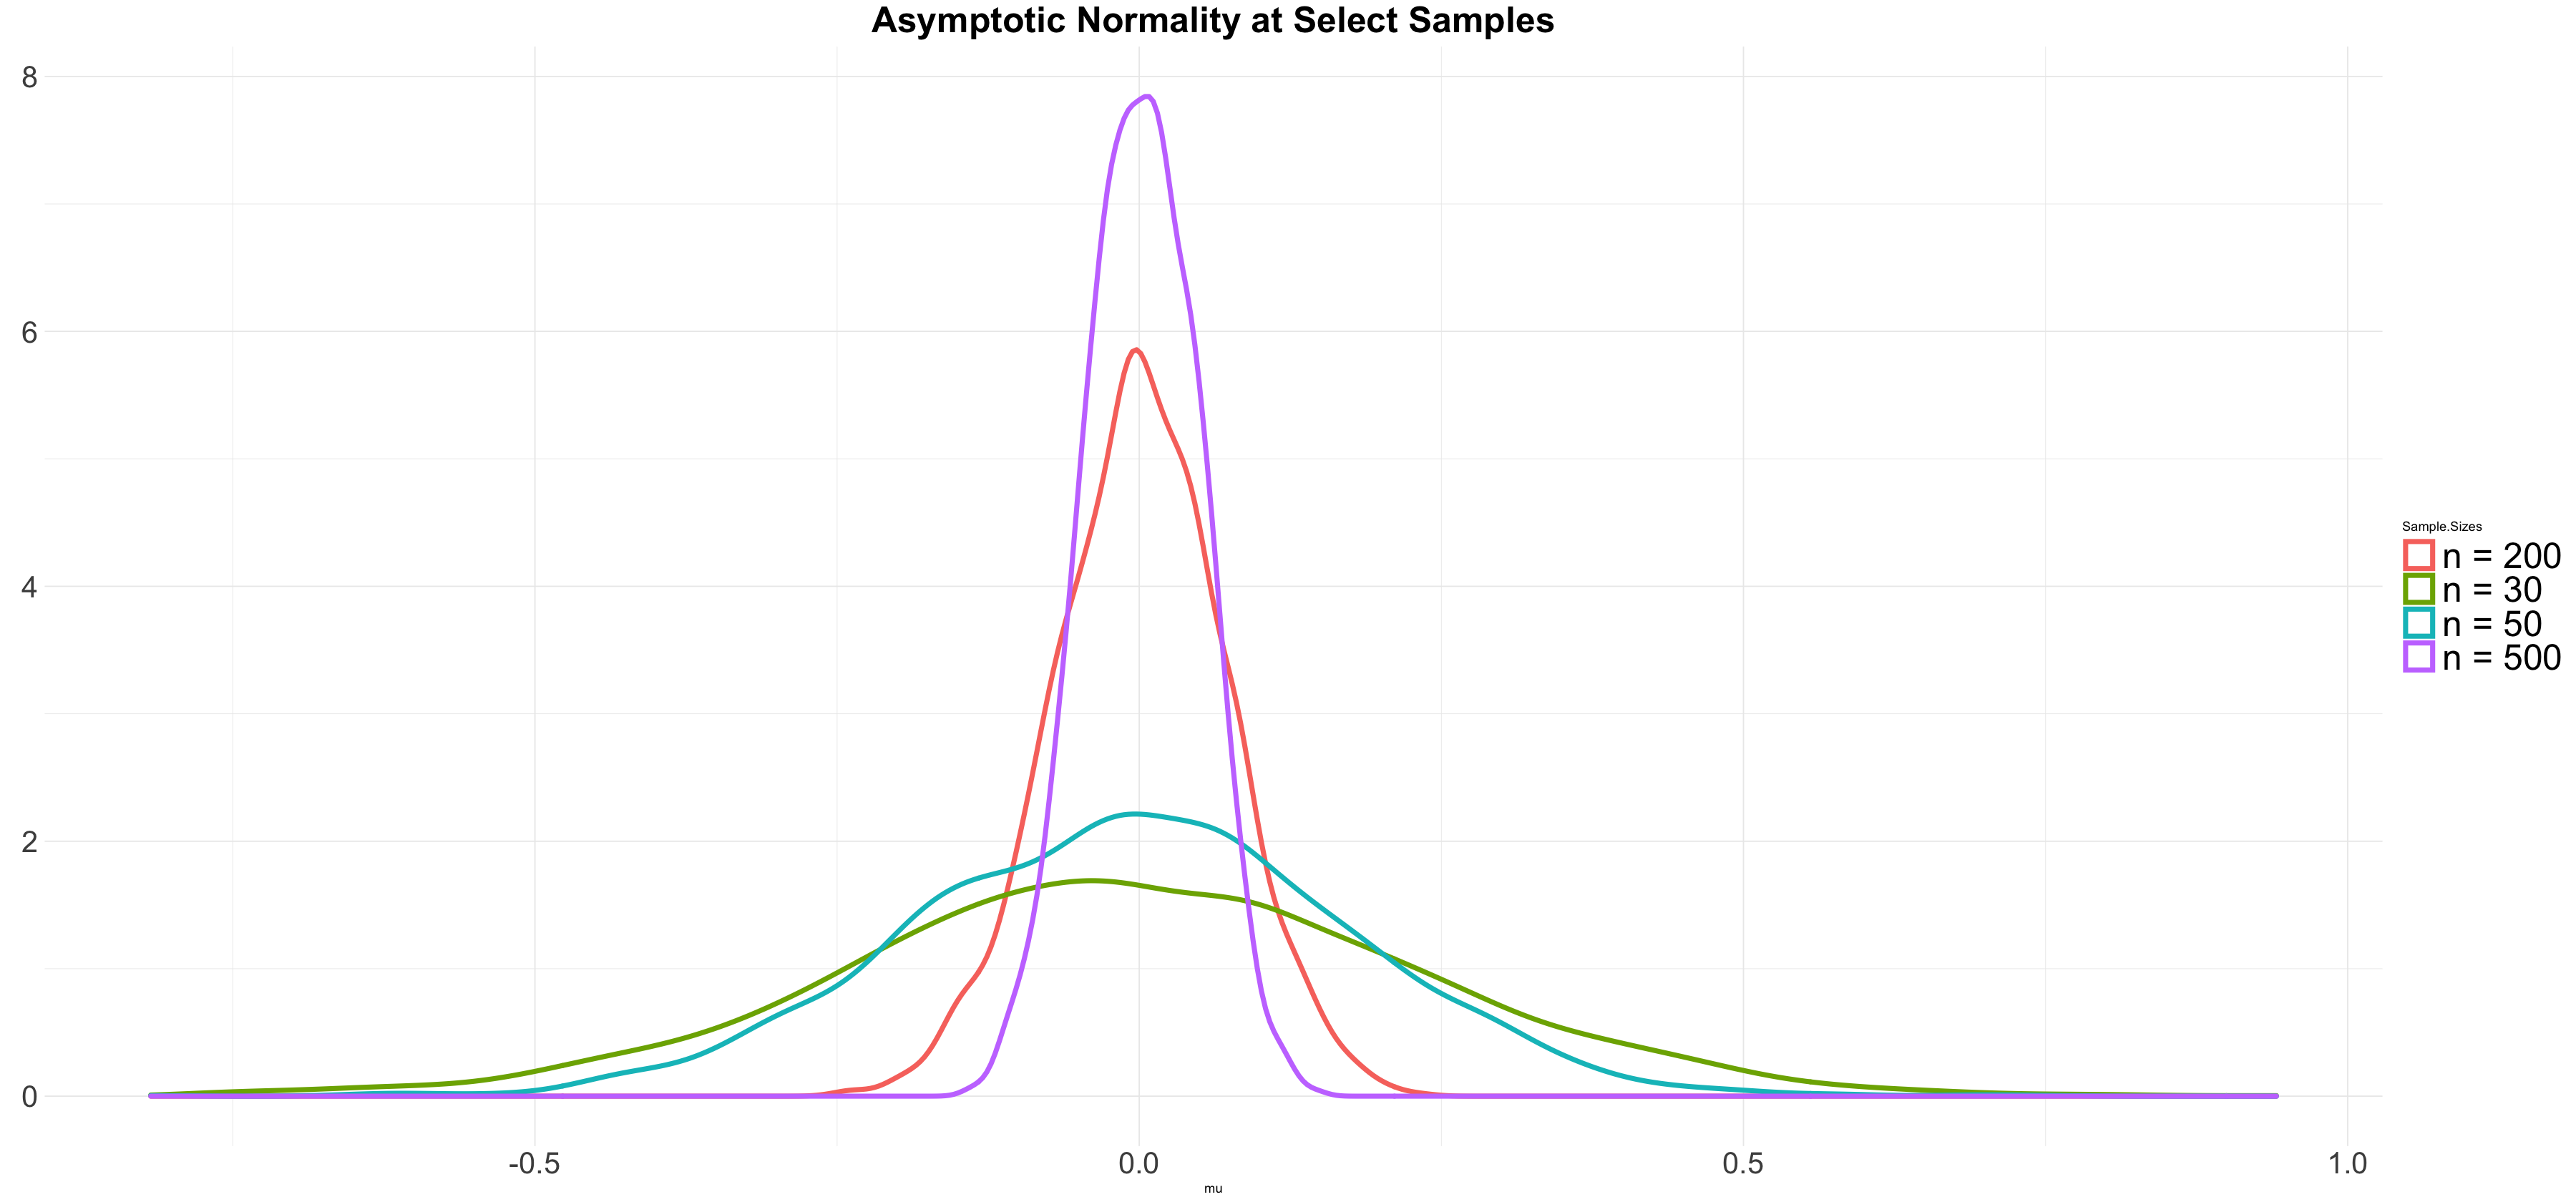

In [268]:
a =  (all_theta_estimates[,1] - theta)
b =  (all_theta_estimates[,2] - theta)
c =  (all_theta_estimates[,3] - theta)
d =  (all_theta_estimates[,4] - theta)

collapse <- data.frame(c(rep(paste0("n = ", n_obs_vec[1]),n_rep),
                         rep(paste0("n = ", n_obs_vec[2]),n_rep),
                         rep(paste0("n = ", n_obs_vec[3]),n_rep),
                         rep(paste0("n = ", n_obs_vec[4]),n_rep)),c(a,b,c,d))

colnames(collapse)<-c("Sample.Sizes","Distribution")

ggplot(collapse, aes(x=Distribution,color=Sample.Sizes)) +
        geom_density(lwd = 2,linetype = 1) +
        #xlim(c(-5, 5)) + ylim(c(0, 0.45)) + 
        xlab("mu") + ylab("") + theme_minimal() + 
        theme(legend.key.size = unit(1, 'cm'),legend.text = element_text(size=30)) +
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=25)) +
        #stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Asymptotic Normality at Select Samples")) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

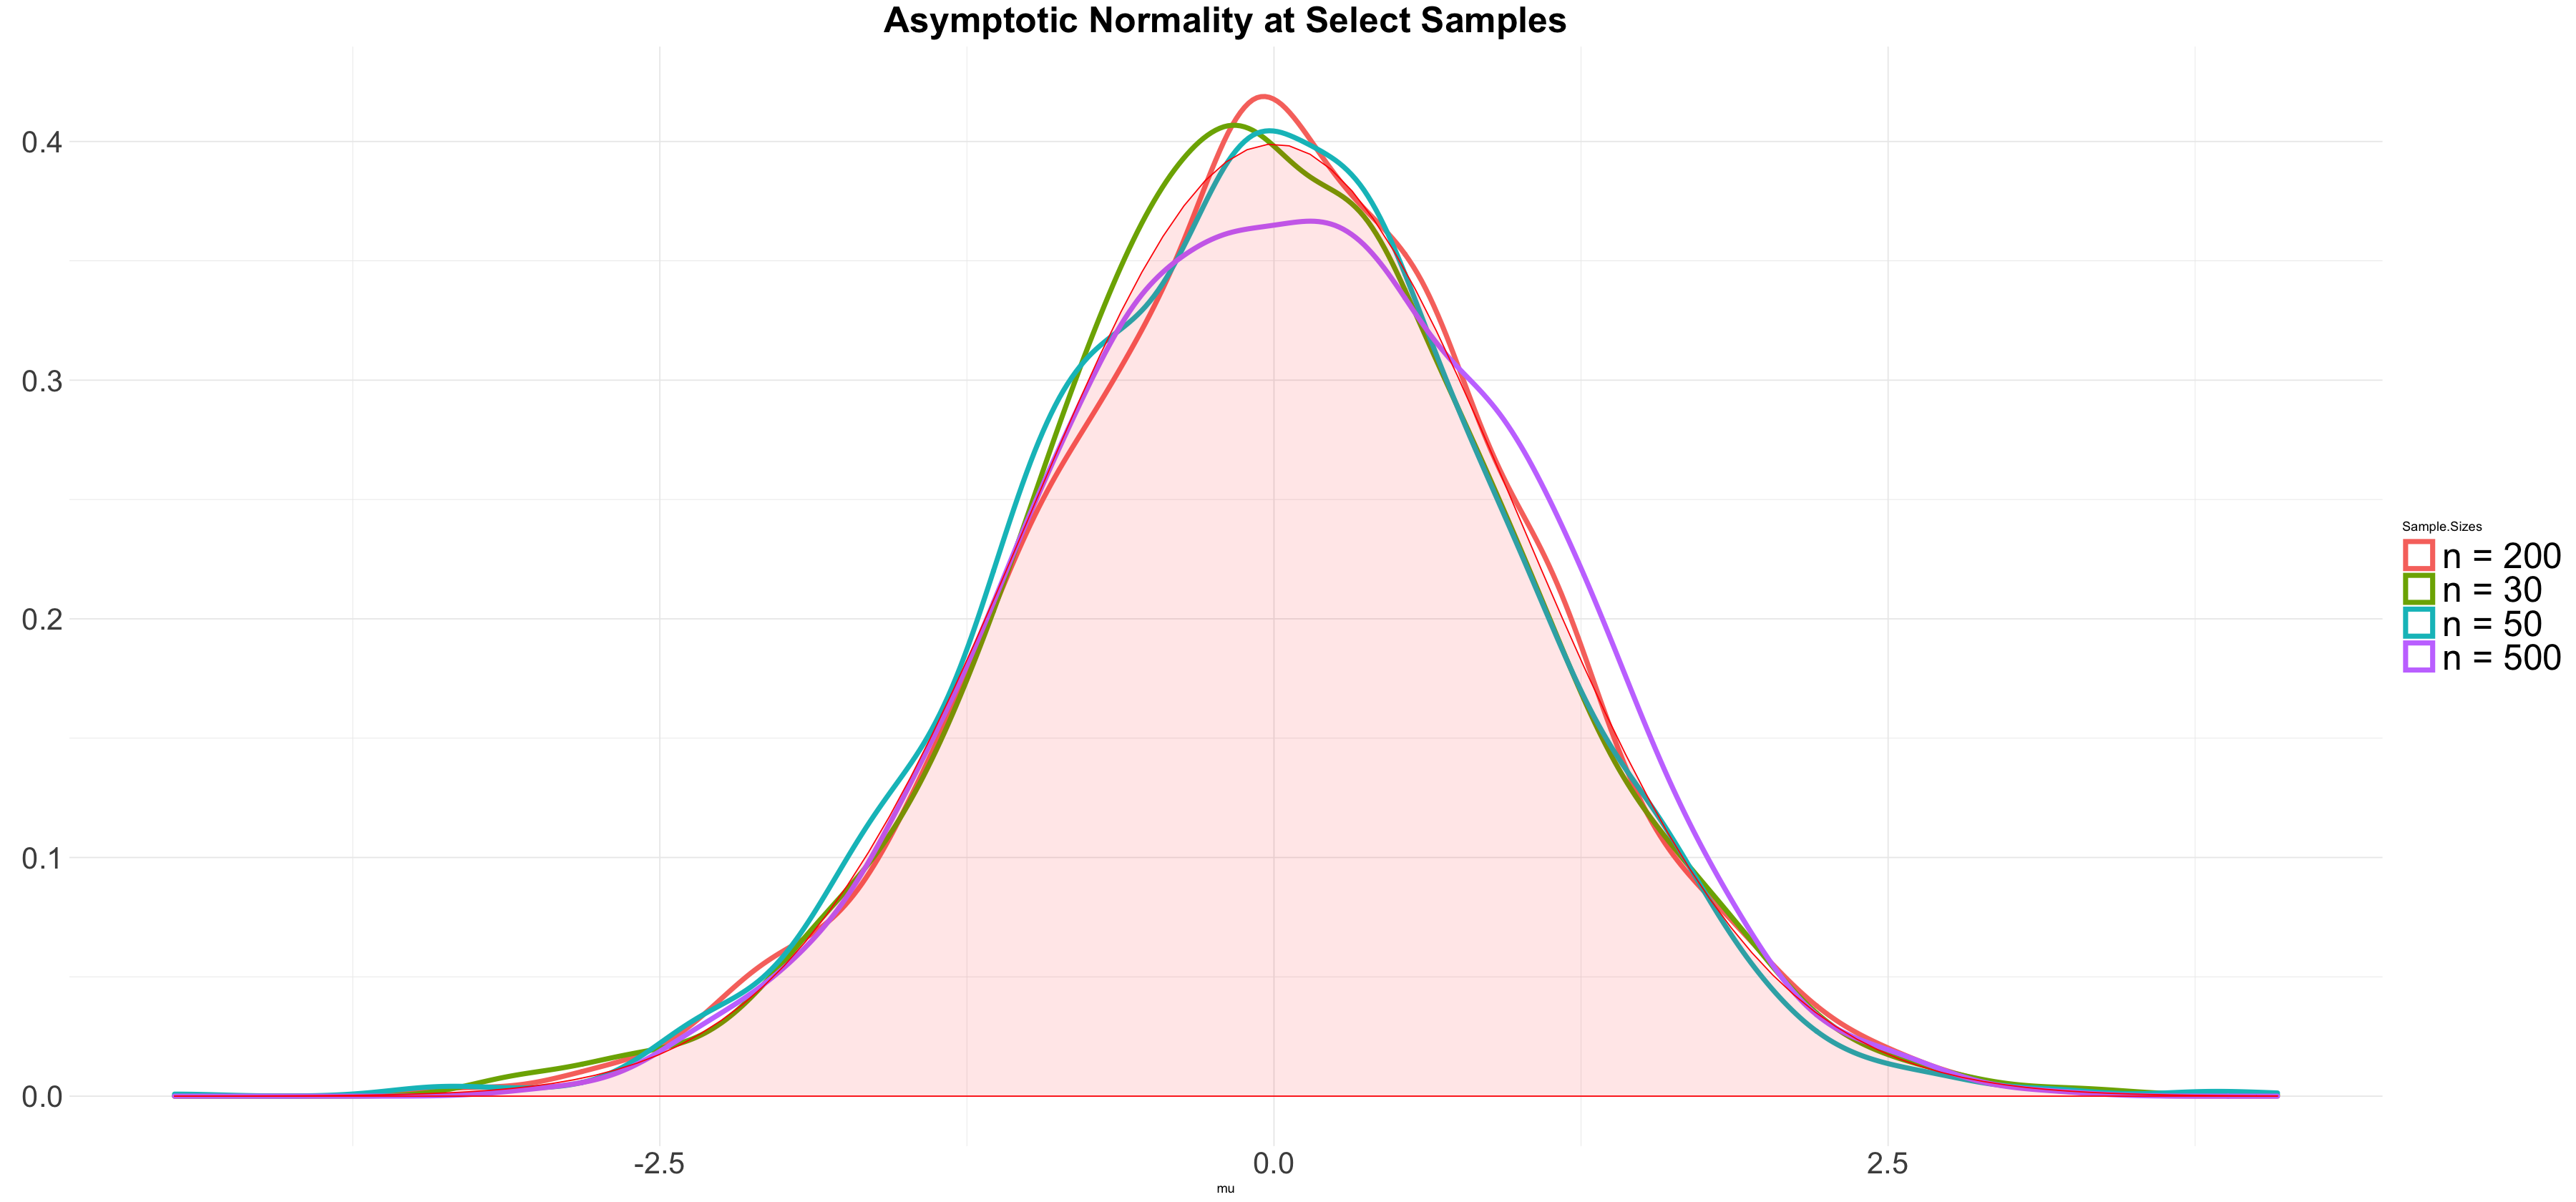

In [284]:
a = (all_theta_estimates[,1] - theta)/sd((all_theta_estimates[,1]))
b = (all_theta_estimates[,2] - theta)/sd((all_theta_estimates[,2]))
c = (all_theta_estimates[,3] - theta)/sd((all_theta_estimates[,3]))
d = (all_theta_estimates[,4] - theta)/sd((all_theta_estimates[,4]))

collapse <- data.frame(c(rep(paste0("n = ", n_obs_vec[1]),n_rep),
                         rep(paste0("n = ", n_obs_vec[2]),n_rep),
                         rep(paste0("n = ", n_obs_vec[3]),n_rep),
                         rep(paste0("n = ", n_obs_vec[4]),n_rep)),c(a,b,c,d))

colnames(collapse)<-c("Sample.Sizes","Distribution")

ggplot(collapse, aes(x=Distribution,color=Sample.Sizes)) +
        geom_density(lwd = 2,linetype = 1) +
        #xlim(c(-5, 5)) + ylim(c(0, 0.45)) + 
        xlab("mu") + ylab("") + theme_minimal() + 
        theme(legend.key.size = unit(1, 'cm'),legend.text = element_text(size=30)) +
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=25)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.1) + 
        ggtitle(paste0("Asymptotic Normality at Select Samples")) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

#### Scenario 2.4: : DML Simulation using single pre-treatment confounder

In [ ]:
n_con = 1      # single confounder

boot_fx <- function(iteration) {
        
    data = confounded_DGP_PRE(theta=theta, n_obs=n_obs, dim_x=n_vars, n_con=n_con,s=s,seed=iteration) # use default DGP provided in packages (chernozhukov 2018)
    output.vec <- sim_function(data)
    return(output.vec) 
}

combined_vec_3  <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_3 <- do.call(rbind, combined_vec_3)

In [ ]:
# Plotting the distribution of scaled estimation
theta_hat_case3 <- all_estimates_3
df_case3 = data.frame(theta_hat_case3 = theta_hat_case3 - theta)
sd_case3 = sd(theta_hat_case3)

df_case3_scaled = data.frame("theta_hat_case3" = df_case3$d/sd_case3)

fig4 = ggplot(df_case3_scaled, aes(x = theta_hat_case3)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig4

#### Scenario 2.5: DML Simulation using single post-treatment confounder

In [ ]:
n_con = 1

boot_fx <- function(iteration) {
        
    data = confounded_DGP_POST(theta=theta, n_obs=n_obs, dim_x=n_vars, n_con=n_con,s=s,seed=iteration) # use default DGP provided in packages (chernozhukov 2018)
    output.vec <- sim_function(data)
    return(output.vec) 
}

combined_vec_4  <- mclapply(1:n_rep, boot_fx, mc.set.seed = TRUE, mc.cores = numCores)
all_estimates_4 <- do.call(rbind, combined_vec_4)

In [ ]:
# Plotting the distribution of scaled estimation from Case 1: No unconfoundedness, n = 200
theta_hat_case4 <- all_estimates_4
df_case4 = data.frame(theta_hat_case4 = theta_hat_case4 - theta)
sd_case4 = sd(theta_hat_case4)

df_case4_scaled = data.frame("theta_hat_case4" = df_case4$d/sd_case4)

fig5 = ggplot(df_case4_scaled, aes(x = theta_hat_case4)) +
        geom_histogram(aes(y=..density..), bins = 100, fill = "dodgerblue4", alpha = 0.3, color = "dark blue") +
        geom_vline(aes(xintercept = 0), col = "black") +
        xlim(c(-10, 10)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Scaled Estimation Error n = ", n_obs, ", p = ", n_vars)) + theme(plot.title = element_text(face="bold", hjust = 0.5))
options(repr.plot.width=30, repr.plot.height=14)

fig5

In [1]:
#plot(density(thetahat[,1]),xlim=c(0.3,0.7),ylim=c(0,14))
df_normality <- data.frame(all_theta_estimates = all_theta_estimates - theta)
sd_normality <- apply(all_theta_estimates, 2, sd)

df_normality_scaled <- data.frame("all_theta_estimates" = sweep(df_normality, 2, sd_normality, FUN = '/'))

df_normality_collapse <- data.frame(c(rep(paste0("n = ", n_obs_vec[1]),n_rep), 
                                      rep(paste0("n = ", n_obs_vec[2]),n_rep), 
                                      rep(paste0("n = ", n_obs_vec[3]),n_rep),
                                      rep(paste0("n = ", n_obs_vec[4]),n_rep)),
               c(df_normality_scaled[,1],df_normality_scaled[,2],df_normality_scaled[,3], df_normality_scaled[,4]))
colnames(df_normality_collapse)<-c("Data","Distribution")

ggplot(df_normality_collapse, aes(x=Distribution,color=Data)) +
        geom_density(alpha=0.01) +
        xlim(c(-8, 8)) + ylim(c(0, 0.5)) + xlab("") + ylab("") + theme_minimal() + 
        theme(plot.title = element_text(color="black", face="bold", size=30),axis.text=element_text(size=20)) +
        stat_function(fun = dnorm, args = list(mean = 0, sd = 1), geom = "area", col = "red", fill = "red", alpha = 0.01) + 
        ggtitle(paste0("Asymptotic Normality at Select Samples")) + theme(plot.title = element_text(face="bold", hjust = 0.5)) +
        theme_grey(base_size = 35)
options(repr.plot.width=30, repr.plot.height=14)

ERROR: Error in data.frame(all_theta_estimates = all_theta_estimates - theta): object 'all_theta_estimates' not found
